In [1]:
import pandas as pd
import matplotlib.pyplot as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cleandata
%matplotlib inline

# Golf Game Improvement Model


### Personal Data

Each record in my data set represents a round of golf that I played and includes attributes about that round such as the score and stats (e.g. number of putts, number of fairways).

In [2]:
# Import Round Data
personal_scores = cleandata.load_personal_data()
personal_scores.head()

,Date,Course,Course Rating,Par,Score,Putts,Fairways,Greens,Holes Played,Relative Score,Relative Score w/ Rating
0,2019-07-20,Wilshire Country Club,71.8,71,98,34.0,5.0,4.0,18,9,26.2
2,2019-07-27,Wilshire Country Club,71.8,71,98,33.0,10.0,3.0,18,20,26.2
3,2019-06-16,Sandpiper,75.1,72,86,32.0,5.0,4.0,18,15,10.9
4,2019-08-17,Wilshire Country Club,71.8,71,91,29.0,5.0,0.0,18,18,19.2
5,2019-08-24,Wilshire Country Club,71.8,71,83,28.0,5.0,4.0,18,12,11.2


**Scores Plotted Over Time**

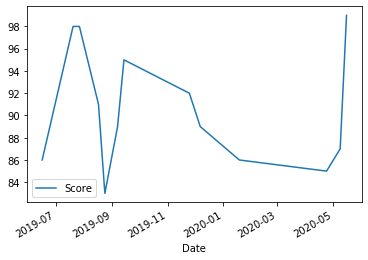

In [3]:
personal_scores.plot(x="Date", y="Score")

**Distribution of Scores**

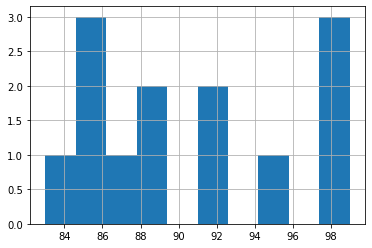

In [4]:
# Distribution of scores
personal_scores['Score'].hist()

**Average Stats Given Score Ranges**

In [5]:
def find_stats(input_score):
    df = personal_scores[(personal_scores["Score"] > input_score) & (personal_scores["Score"] < input_score + 10) & (personal_scores["Holes Played"] == 18)]
    df = pd.DataFrame(df[['Putts','Fairways','Greens']].mean())
    df.columns = [str(input_score) + 's']
    return df

shoot_80s = find_stats(input_score = 80)
shoot_90s = find_stats(input_score = 90)
shoot_80s.merge(shoot_90s, left_index=True, right_index = True)

,80s,90s
Putts,30.571429,34.000000
Fairways,5.857143,5.833333
Greens,4.000000,3.166667


**Correlation Matrix of Scores and Stats**

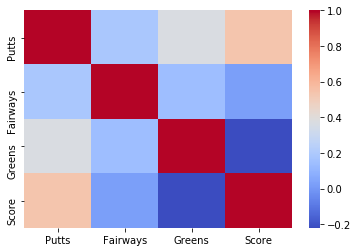

In [6]:
correlations = personal_scores[["Putts", "Fairways", "Greens", "Score"]].corr()
sns.heatmap(correlations, cmap='coolwarm')

Putts is the most highly correlated skill with Score. As a players number of Putts increase, the score also increases. Greens has a negative correlation with Score. As a players number of Greens increases, their score decreases. Fairways has the weakest correlation with Score.

**Scatterplot: The Relationship Between Stats and Score**

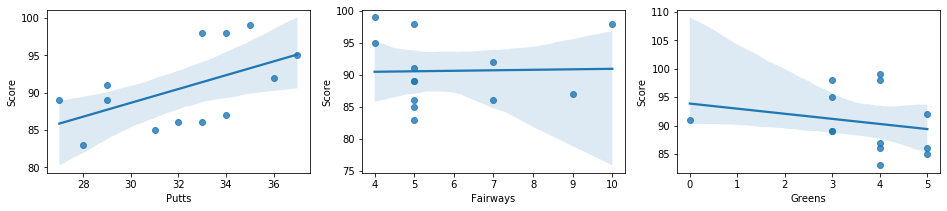

In [7]:
fig, axs = plt.subplots(1, 3, sharey=False,figsize=(16, 3))
sns.regplot(x=personal_scores.Putts, y=personal_scores.Score, ax=axs[0])
sns.regplot(x=personal_scores.Fairways, y=personal_scores.Score, ax=axs[1])
sns.regplot(x=personal_scores.Greens, y=personal_scores.Score, ax=axs[2])

### PGA Tour Data

Each record in this PGA Tour dataset represents a player and a summary of statistics for all the rounds they played between 2010 and 2018. Let's see how their stats compare to my stats.

In [8]:
# Import PGA Tour Data
pro_scores = cleandata.load_pro_data()

**Distribution of Scores**

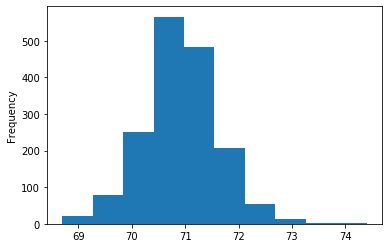

In [9]:
pro_scores['Score'].plot(kind='hist')

**Average Stats Given Scores**

In [10]:
def find_avg_stats(score):
    stats = pro_scores[(pro_scores['Score'] >= score) & (pro_scores['Score'] < (score+1))].mean()
    return stats.rename(score)

attributes = pd.DataFrame()
for i in range(69,75):
    stats = find_avg_stats(i)
    attributes = attributes.append(stats)
    
attributes

,Fairways,Greens,Holes Played,Putts,Score
69,8.668312,12.181105,18.0,28.902197,69.676947
70,8.689830,11.945433,18.0,29.111790,70.601705
71,8.527404,11.660652,18.0,29.246195,71.385104
72,8.320646,11.344292,18.0,29.486923,72.297560
73,8.132400,10.861457,18.0,29.327143,73.219714
74,6.187300,9.720000,18.0,28.905000,74.331000


### Adding Pro Scores to My Scores

By adding in average stats for professional golfers, I can create a more robust model that works for my scores as well as the low scores that professionals shoot, and hopefully the scores in between too.

In [11]:
new = pd.DataFrame()
for i in range(70,75):
    test = pro_scores[(pro_scores['Score'] >= i) & (pro_scores['Score'] < (i+1))].sample(n=2, random_state=24)
    new = new.append(test, ignore_index = True)
personal_scores_added_pros = pd.concat([personal_scores,new])

**Scatterplot: The Relationship Between Stats and Score**

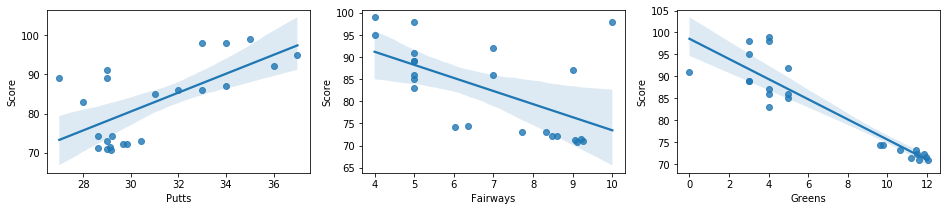

In [12]:
fig, axs = plt.subplots(1, 3, sharey=False,figsize=(16, 3))
sns.regplot(x=personal_scores_added_pros.Putts, y=personal_scores_added_pros.Score, ax=axs[0])
sns.regplot(x=personal_scores_added_pros.Fairways, y=personal_scores_added_pros.Score, ax=axs[1])
sns.regplot(x=personal_scores_added_pros.Greens, y=personal_scores_added_pros.Score, ax=axs[2])

### Applying a Linear Model

The scatterplots show a possible linear relationship between each of the stats and the overall score. I fit the data with a model to understand the linear relationship between putts, greens, and fairways, with a target variable of score.

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, KFold

In [14]:
def fit_and_score_linear_model(data,target):
    
    # Define features
    features = ['Putts','Fairways','Greens']
    X = data[features]
    y = data[target]
    
    # Fit linear regression model
    lr = LinearRegression()
    lr.fit(X,y)
    y_pred = lr.predict(X)
    r2 = lr.score(X,y)
    
    # Cross validate model
    kf = KFold(n_splits = 5, shuffle=True, random_state=24)
    cv_results = cross_validate(lr,X,y,scoring='r2',cv=kf)
    
    print('r2 training: '+str(r2))
    print('r2 cross val: ' +str(cv_results['test_score'].mean()))
    
    return {'model':lr, 'predicted': y_pred}

In [15]:
test1 = fit_and_score_linear_model(personal_scores,'Score')

r2 training: 0.5005286435494004
r2 cross val: -2.370294280122853


In [16]:
test2 = fit_and_score_linear_model(personal_scores_added_pros,'Score')

r2 training: 0.9205079679115369
r2 cross val: 0.8118472290929105


In [17]:
test3 = fit_and_score_linear_model(personal_scores,'Relative Score w/ Rating')

r2 training: 0.509141104502872
r2 cross val: -1.3002199380952846


In [18]:
IDEAL_MODEL = test2['model']
with open('exports/Score.pkl', 'wb') as picklefile:
    pickle.dump(IDEAL_MODEL, picklefile)

In [19]:
print('coeffs: ' + str(IDEAL_MODEL.coef_))
print('intercept: ' + str(IDEAL_MODEL.intercept_))

coeffs: [ 1.23777615 -0.06265284 -1.91760438]
intercept: 58.10202779759855


The best performing model uses the data that has pro scores included. The coefficients from the linear model can be used to create an equation that predicts the score based on the number of putts, fairways, and greens. The number of greens hit has the biggest impact on overall score.

$$y = 1.2p - .06f - 1.9g + 58$$

### Applying a Random Forest Regressor

In an attempt to increase the accuracy of my predictions, I fitted the same data with a random forest decision tree. The model produced a very high of training R2 of .97 but the score dropped significantly after being cross validated, which is a sign that the model may have overfit the data.

In [20]:
from sklearn.ensemble import RandomForestRegressor

features = ['Putts','Fairways','Greens']
target = 'Score'
X = personal_scores_added_pros[features]
y = personal_scores_added_pros[target]

In [21]:
rf = RandomForestRegressor()
rf.fit(X,y)
rf.score(X,y)

0.9791592310938143

In [22]:

kf = KFold(n_splits = 5, shuffle=True, random_state=24)
cv_results = cross_validate(rf,X,y,scoring='r2',cv=kf,return_estimator=True)
print(cv_results['test_score'].mean())

0.7902448905910285


### Output and Optimization

There are a few ways to use the model in order to generate a prediction. You can use the linear equation to solve for the target score given a specific stats. Or you can provide a range for each stat and use an optimization algorithm to predict the lowest score possible.


**Predict Target Score Based On Stats**

In [26]:
IDEAL_MODEL.predict(pd.DataFrame({'Putts': [34.0],'Fairways': [7.0],'Greens': [7.0]}))[0]

86.32461644622471

**Predict Target Score Based On Range of Stats**

In [27]:
from scipy.optimize import linprog

c = IDEAL_MODEL.coef_
putts_bounds = (30,32)
fairways_bounds = (5,7)
greens_bounds = (6,9)
result = linprog(c,  bounds=[putts_bounds, fairways_bounds, greens_bounds])
output = result.fun + IDEAL_MODEL.intercept_
output

77.53830308169394

**Predict Target Score Based On Range of Stats**

In [25]:
features = ['Putts','Fairways','Greens']
X = personal_scores_added_pros['Score'].values.reshape(-1, 1)
models = {}
for feature in features:
    y = personal_scores_added_pros[feature]
    lr = LinearRegression()
    lr.fit(X,y)
    y_pred = lr.predict(np.array([72]).reshape(-1, 1))
    r2 = lr.score(X,y)
    print(feature + ' r2: ' + str(r2))
    models[feature] = lr
    with open('exports/'+feature+'.pkl', 'wb') as picklefile:
        pickle.dump(lr, picklefile)
    
def get_target_stats(target_score):
    target_stats = []
    for feature in features:
        target_stat = models[feature].predict(np.array([target_score]).reshape(-1, 1))
        target_stats.append(target_stat[0])
    
    return target_stats

Putts r2: 0.4376226712762414
Fairways r2: 0.33419701771183197
Greens r2: 0.8258304537080158


In [28]:
get_target_stats(90)

[32.23043407793887, 6.049196792958897, 4.275130267447736]

### Discussion

There are several areas where this model could be improved or expanded in the future...

More data - The sample size is small, which leads to inconsistent results when trying to cross validate the model and find the out-of-sample accuracy. The values change drastically dending on what subset of the data is selected in the KFolds.

Representative of all golfers - The data used to train the model is only representative of my skills and the skills of touring professions, leaving a big gap in the dataset. The model needs additional samples from advanced players who shoot between 75 - 80 and beginner players who shoot > 100. Filling in this gap could allow me to explore different models that may result in a more accurate prediction.

Consistent sampling methods - The data for my personal scores were collected in a different way than the data for the pro scores. Each sample in of pro scores was an average of stats over many rounds. Each sample of my scores represented a specific round I played. Taking averages can remove important variance in the data that can be used to make more accurate predictions.

More features - There is potential to create/modify features that are more closely related to score. For example, not all courses have the same number of fairways. By creating a feature that details the number of fairways on the course, we could transform the Fairways stat into a percentage rather than an absolute number.